In [1]:
from bs4 import BeautifulSoup
import requests
import html
import time
import argparse


In [2]:
import mygene
mg = mygene.MyGeneInfo()


In [3]:
# changing the gene identification from entrezgene to symbol by mygene library
mg.querymany("5087", scopes='entrezgene', fields='symbol', species='human')[0]['symbol']



querying 1-1...done.
Finished.


'PBX1'

In [4]:
# files should not have spaces
optimal_data_set_file = '/Users/farhadzare/Desktop/Endothelium/optimal_dataset.csv' 
optimal_data_set_names_file = '/Users/farhadzare/Desktop/Endothelium/optimal_dataset_list.csv'
metadata_folder = '/Users/farhadzare/Desktop/Endothelium/metadata/'


In [5]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns


# Changing the genes ID

In [6]:
expression_df=pd.read_csv(optimal_data_set_file )


In [7]:
GeneID=expression_df['Feature']


In [8]:
GS=mg.querymany(GeneID, scopes='entrezgene', fields='symbol', species='human')
GeneSymbol=[GS[i]['symbol'] for i in range(4998)]


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4998...done.
Finished.


In [9]:
len(set(GeneSymbol))


4998

In [10]:
expression_df['Gene ID']=GeneSymbol


In [11]:
expression_df=expression_df.drop(['Feature'], axis=1)



In [12]:
expression = expression_df.set_index("Gene ID")
expression.rename_axis(None, inplace=True)
print(expression.shape)


(4998, 2636)


In [13]:
expression.head()


,E-GEOD-30169_GSM752709.cel,E-GEOD-30169_GSM752710.cel,E-GEOD-30169_GSM752711.cel,E-GEOD-30169_GSM752712.cel,E-GEOD-30169_GSM752713.cel,E-GEOD-30169_GSM752714.cel,E-GEOD-30169_GSM752715.cel,E-GEOD-30169_GSM752716.cel,E-GEOD-30169_GSM752717.cel,E-GEOD-30169_GSM752718.cel,...,E-GEOD-2450_GSM46386.CEL,E-GEOD-2450_GSM46387.CEL,E-GEOD-2450_GSM46388.CEL,E-GEOD-2450_GSM46389.CEL,E-GEOD-2450_GSM46390.CEL,E-GEOD-2450_GSM46391.CEL,E-GEOD-2450_GSM46392.CEL,E-GEOD-2450_GSM46393.CEL,E-GEOD-2450_GSM46394.CEL,E-GEOD-2450_GSM46395.CEL
ADA,6.082276,6.296477,5.678143,5.903716,6.561618,6.563634,6.315923,6.285618,6.213070,6.462815,...,6.277586,6.319818,6.377999,6.527582,6.489835,6.624150,8.837815,8.586964,6.352242,6.281925
CDH2,8.910453,9.094440,9.018398,8.981716,9.903595,9.752144,10.060706,10.016482,10.449370,10.395254,...,8.676218,8.441180,8.843971,8.998472,8.892125,8.860669,9.992499,10.019584,8.024033,7.984392
AKT3,3.903745,3.573659,3.750108,4.090731,3.960562,3.867853,3.701989,3.649789,3.906663,3.963748,...,6.441616,6.292823,6.226290,6.620311,6.222595,6.497028,7.098504,7.330978,6.436398,6.473776
ACOT8,5.963907,6.097107,5.790247,5.761399,6.016096,6.124152,6.104648,5.986309,5.860771,6.024226,...,7.281914,7.315629,7.086792,7.135733,7.045656,6.585559,7.457399,8.094391,6.995187,7.402195
ABI1,7.752008,7.465366,7.941747,7.606796,7.469340,7.268851,7.641408,7.385734,7.565066,7.325005,...,6.486721,6.146278,5.913813,5.738923,6.470929,6.267256,6.340759,7.332293,5.348349,5.980073


# Adding tissues to the data set form metadata

In [14]:
# get working studies
df = pd.read_csv(optimal_data_set_names_file)
working_studies_data_files = df.iloc[:, -1].to_list()
print(len(working_studies_data_files), working_studies_data_files[:5])

working_studies_metadata_files = [element.replace('data', 'metadata') for element in working_studies_data_files]
print(len(working_studies_metadata_files), working_studies_metadata_files[:5])



168 ['E-GEOD-30169 data.csv', 'E-GEOD-5883 data.csv', 'E-GEOD-3920 data.csv', 'E-GEOD-5556 data.csv', 'E-GEOD-69996 data.csv']
168 ['E-GEOD-30169 metadata.csv', 'E-GEOD-5883 metadata.csv', 'E-GEOD-3920 metadata.csv', 'E-GEOD-5556 metadata.csv', 'E-GEOD-69996 metadata.csv']


In [15]:
# read tissue of origin
tissues_of_origin = []
for element in working_studies_metadata_files:
    file = metadata_folder + element
    df = pd.read_csv(file, encoding='latin1')
    
    # check that species is human
    species = list(set(df['Species'].to_list()))
    if species != ['Homo sapiens']:
        print('ERROR about species')
        
    # get tissue of origin for this study
    tissue_of_origin = df['Organ'].to_list()
    for element in tissue_of_origin:
        tissues_of_origin.append(element)
    
# checking number of metadata elements
print(len(tissues_of_origin))



2636


In [16]:
# bring to "Other" if tissue of origin in less common than n samples
threshold = 10 # a threshold of 10 provides 20 groups which is perfect for tab20
unfrequent_tissues = []
unique_tissues = list(set(tissues_of_origin))
for element in unique_tissues:
    if tissues_of_origin.count(element) < threshold:
        unfrequent_tissues.append(element)

for i in range(len(tissues_of_origin)):
    if tissues_of_origin[i] in unfrequent_tissues:
        tissues_of_origin[i] = 'Other'
        
# checking frequencies
unique_tissues = list(set(tissues_of_origin))
for i in range(len(unique_tissues)):
    print(i, unique_tissues[i], tissues_of_origin.count(unique_tissues[i]))
    
    

0 Eye 50
1 Bone 43
2 Somatic cell hybrid 12
3 Intestine 48
4 Lymphatic system 27
5 Aorta 723
6 Lung 157
7 Umbilical cord blood 41
8 Blood 140
9 Brain 34
10 Blood vessel 12
11 Umbilical cord 887
12 Uterus 10
13 Skin 113
14 Liver 84
15 Kidney 14
16 Other 34
17 Placenta 19
18 Peripheral blood 24
19 Heart 164


In [17]:
import matplotlib
# compute colors
tissue_ranks = [unique_tissues.index(element) for element in tissues_of_origin]

# checking
print('checking...')
for i in range(len(list(set(tissue_ranks)))):
    print(i, tissue_ranks.count(i))

# mapping
my_map = matplotlib.cm.get_cmap('tab20')
working_colors = my_map(tissue_ranks)



checking...
0 50
1 43
2 12
3 48
4 27
5 723
6 157
7 41
8 140
9 34
10 12
11 887
12 10
13 113
14 84
15 14
16 34
17 19
18 24
19 164


# Restrictions and Normalization of data 

In [18]:
Aortalist=[]
for i in range(len(tissues_of_origin)):
    if tissues_of_origin[i]=='Aorta':
        Aortalist.append(i)
        



In [19]:
# restrict data to Aorta part 
ex_matrix =expression.iloc[0:1000,Aortalist].T
ex_matrix


,ADA,CDH2,AKT3,ACOT8,ABI1,GNPDA1,TANK,HDAC6,PDCD6IP,SH2B3,...,CLUAP1,TBC1D9B,GGA2,WAPL,SETX,EMC1,ERP44,BLTP3B,SWAP70,RRP1B
E-GEOD-30169_GSM752709.cel,6.082276,8.910453,3.903745,5.963907,7.752008,7.375102,5.187760,5.620045,10.513556,9.541779,...,6.573587,7.366281,4.520462,7.649978,6.515985,6.636114,4.399774,4.787275,4.081858,9.582021
E-GEOD-30169_GSM752710.cel,6.296477,9.094440,3.573659,6.097107,7.465366,7.314584,4.776528,5.593111,10.304974,9.013600,...,6.666182,7.354129,4.205761,7.236840,6.086462,6.572052,4.398890,4.647383,4.041984,9.293093
E-GEOD-30169_GSM752711.cel,5.678143,9.018398,3.750108,5.790247,7.941747,7.420180,5.657152,5.238865,10.533208,9.677985,...,6.402999,7.588944,4.457085,7.652206,6.453483,6.828489,4.192564,5.212552,4.759505,9.213769
E-GEOD-30169_GSM752712.cel,5.903716,8.981716,4.090731,5.761399,7.606796,7.501158,5.115412,5.331495,10.522132,9.546220,...,6.357986,7.319048,4.479705,7.614384,6.545434,6.605899,4.566154,4.879280,4.730473,9.196321
E-GEOD-30169_GSM752713.cel,6.561618,9.903595,3.960562,6.016096,7.469340,7.443952,5.041231,5.256271,10.415659,9.294982,...,6.717917,7.687901,4.428243,7.357628,6.314089,6.659226,4.269930,4.963231,4.918917,9.350938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E-GEOD-60152_GSM1466661_stat_siFoxC2_B2.CEL,7.344756,3.515593,8.513172,6.410922,8.720197,7.020655,6.863063,5.710551,8.470681,7.676424,...,6.235535,6.404562,6.867816,7.825377,7.914351,6.767013,8.166261,5.447796,9.172262,7.651058
E-GEOD-43475_GSM1063377_HAEC1_2.CEL,9.168425,11.205217,7.115713,4.599031,9.551145,10.185907,9.652446,8.005063,8.780931,10.481819,...,7.687916,9.387894,7.459797,8.603539,9.206846,7.108306,5.232545,7.862208,11.348766,9.980657
E-GEOD-43475_GSM1063378_HAEC2_9.CEL,9.453883,11.524640,7.444887,5.219987,8.989087,10.630727,10.262708,7.264559,9.529948,10.525307,...,7.769061,9.179360,7.679123,9.493143,9.832617,8.371354,5.297748,7.791018,11.418911,10.557700
E-GEOD-21212_A_GSM530367.CEL,8.791271,11.010669,9.182348,6.857918,8.474146,8.909936,9.975900,6.487617,11.396659,10.353036,...,7.545251,8.641622,6.820522,8.976626,6.924537,8.962551,10.780633,7.307741,11.213398,6.086417


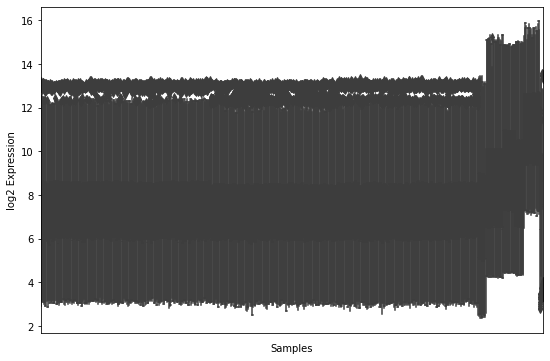

In [20]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = sns.boxplot(data=ex_matrix.T, palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression')
matplotlib.pyplot.show()


The above figure shows that data has not unique scale.

In [21]:
import numpy 
def quantile_normalization(df):
    
    "Quantile normalization consists on sorting, averaging and re-ordering."
    "For more information: https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/"
  
    # step 1/3: sorting sample values
    df_sorted = pd.DataFrame(numpy.sort(df.values, axis=0), index=df.index, columns=df.columns)
    # step 2/3: averaging rank values across samples
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = numpy.arange(1, len(df_mean) + 1)
    # step 3/3: re-ordering samples
    df.rank(method="min").astype(int)
    df_qn = df.rank(method="min").stack().astype(int).map(df_mean).unstack()

    return df_qn



In [22]:
%%time
expression_qn = quantile_normalization(ex_matrix.T)



CPU times: user 269 ms, sys: 37.8 ms, total: 306 ms
Wall time: 305 ms


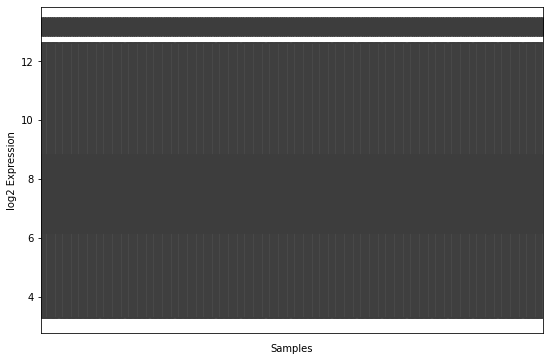

In [23]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = sns.boxplot(data=expression_qn, palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression')
matplotlib.pyplot.show()

In [24]:
ex_matrix=expression_qn.T



# Heatmap and tSNE on gene experssion 

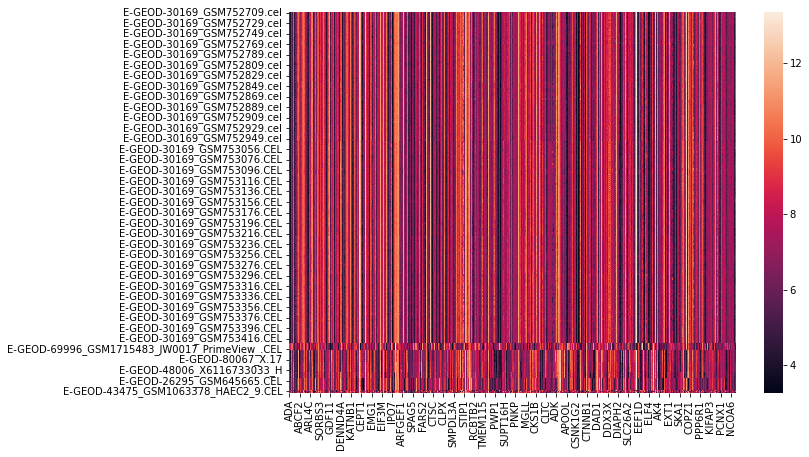

In [25]:
fig = matplotlib.pyplot.figure(figsize =(10, 7))
sns.heatmap(ex_matrix)
matplotlib.pyplot.show()

In [85]:
# the above heatmap divides the gene experesions cells into 4 groups  

/Users/farhadzare/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/farhadzare/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


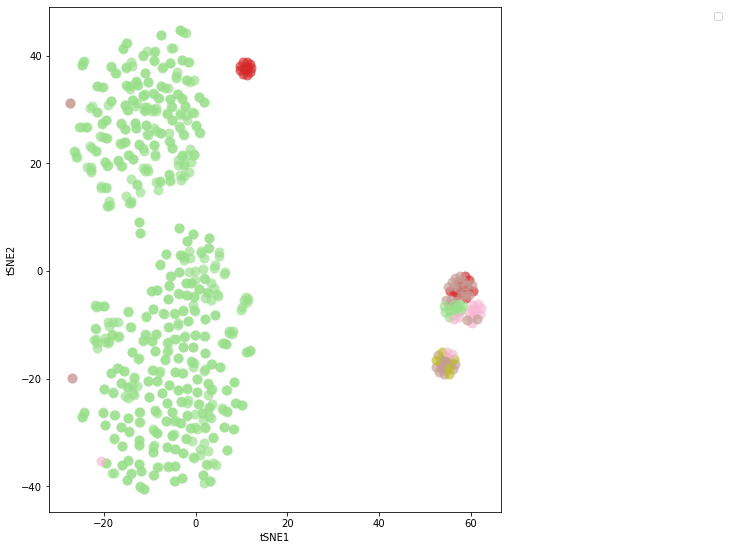

In [27]:
import sklearn, sklearn.manifold, sklearn.preprocessing


embedded = sklearn.manifold.TSNE(perplexity=45, init='pca', random_state=9).fit_transform(expression_qn.T)

matplotlib.pyplot.figure(figsize=(12, 8))
tagged_tissue = []

for i in range(len(embedded)):
    x = embedded[i, 0]
    y = embedded[i, 1]
    matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0)

matplotlib.pyplot.legend(bbox_to_anchor=(1.5, 1), ncol=2)
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout(pad=2)


# GRN and human motifs

In [28]:
DATA_FOLDER="/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/tmp"
RESOURCES_FOLDER="/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/resources"
DATABASE_FOLDER = "/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/"
homoData='/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans'
SCHEDULER="123.122.8.24:8786"
DATABASES_GLOB = os.path.join(homoData, "hg19-*.feather")

MOTIFS_HGNC_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
OUT_TFS_HGNC_FNAME = os.path.join(RESOURCES_FOLDER, 'hs_hgnc_tfs.txt')
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER , "mm_mgi_tfs.txt")
SC_EXP_FNAME = os.path.join(RESOURCES_FOLDER, "GSE60361_C1-3005-Expression.txt")
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs.csv")


In [29]:
os.chdir("/Users/farhadzare/Desktop/Thesis for master/Untitled Folder")


In [30]:
ex_matrix.to_csv('OptimalwID.csv')


In [31]:
df_motifs_hgnc = pd.read_csv(MOTIFS_HGNC_FNAME, sep='\t')
hs_tfs = df_motifs_hgnc.gene_name.unique()
with open(OUT_TFS_HGNC_FNAME, 'wt') as f:
    f.write('\n'.join(hs_tfs) + '\n')
len(hs_tfs)

/var/folders/xw/ggml5mhd4n7315516lvx2p6c0000gn/T/ipykernel_4999/794328062.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_motifs_hgnc = pd.read_csv(MOTIFS_HGNC_FNAME, sep='\t')


1839

In [32]:

OUT_TFS_HGI_FNAME = os.path.join(RESOURCES_FOLDER, 'hs_hgnc_tfs.txt')



In [33]:
OUT_TFS_HGI_FNAME


'/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/resources/hs_hgnc_tfs.txt'

In [34]:
df_motifs_Hgi = pd.read_csv(MOTIFS_HGNC_FNAME , sep='\t')



/var/folders/xw/ggml5mhd4n7315516lvx2p6c0000gn/T/ipykernel_4999/3311561502.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_motifs_Hgi = pd.read_csv(MOTIFS_HGNC_FNAME , sep='\t')


In [35]:
HO_tfs = df_motifs_Hgi.gene_name.unique()
len(HO_tfs)


1839

In [36]:
with open('/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/resources/hs_hgnc_tfs.txt', 'wt') as f:
    f.write('\n'.join(HO_tfs) + '\n')  


In [37]:
tf_names = load_tf_names(OUT_TFS_HGNC_FNAME)


In [38]:
len(tf_names)


1839

# First step (GRNBoost/ GENIE3)

In [40]:
adjancencies = grnboost2(expression_data=ex_matrix, tf_names=tf_names, verbose=True)


preparing dask client


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


parsing input
creating dask graph
4 partitions
computing dask graph
shutting down client and local cluster
finished


In [41]:
adjancencies.head()


,TF,target,importance
17,CEBPG,CEBPB,134.449938
70,EPAS1,EIF4EBP1,112.944231
17,CEBPB,CEBPG,108.342248
40,CREB1,XPO7,105.305357
77,EZH2,NDC80,93.254721


In [42]:
adjancencies.to_csv('ADJACENCIES.csv', index=False, sep='\t')
#adjacencies = pd.read_csv(ADJACENCIES_FNAME, sep='\t')


## Second step: cisTarget identification and motifs for the human genome. 

In [43]:
db_fnames = glob.glob(DATABASES_GLOB)
db_fnames

['/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-tss-centered-10kb-7species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-500bp-upstream-7species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-tss-centered-5kb-7species.mc9nr.genes_vs_motifs.rankings.feather']

In [44]:
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]

when it is needed

for i in db_fnames:
    convert_feather_v1_to_v2_vice_versa(i,i)

In [45]:
for i in db_fnames:
    print(name(i))

hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings
hg19-tss-centered-10kb-7species.mc9nr.genes_vs_motifs.rankings
hg19-500bp-upstream-7species.mc9nr.genes_vs_motifs.rankings
hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings
hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings
hg19-tss-centered-5kb-7species.mc9nr.genes_vs_motifs.rankings


In [46]:
dbs = [RankingDatabase(fname=i, name=name(i)) for i in db_fnames]


In [47]:
dbs


[FeatherRankingDatabase(name="hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-tss-centered-10kb-7species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-500bp-upstream-7species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-tss-centered-5kb-7species.mc9nr.genes_vs_motifs.rankings")]

In [48]:
modules = list(modules_from_adjacencies(adjancencies, ex_matrix))




2022-08-20 17:10:17,280 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-08-20 17:10:17,300 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-08-20 17:10:18,020 - pyscenic.utils - INFO - Creating modules.


In [49]:
print(len(modules))



511


# modules and distribution

In [50]:
Rank_module=[]
for i in range(len(modules)):
    Rank_module.append(len(modules[i]))
    

Text(0, 0.5, "frequency of modules' length")

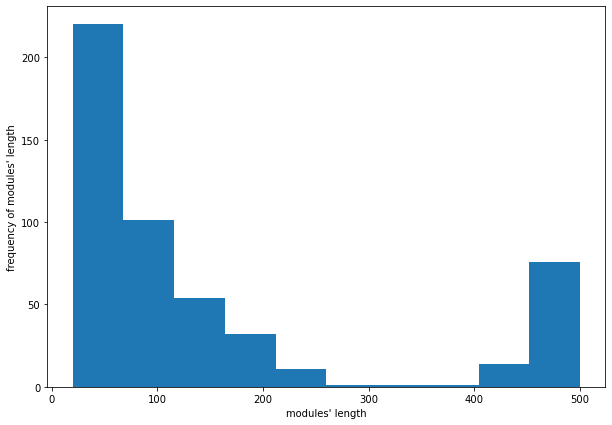

In [51]:
fig = matplotlib.pyplot.figure(figsize =(10, 7))
matplotlib.pyplot.hist(Rank_module)
matplotlib.pyplot.xlabel("modules' length")
matplotlib.pyplot.ylabel("frequency of modules' length")



# Regulons and its distribution

In [52]:
# Calculate a list of enriched motifs and the corresponding target genes for all modules.
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

# Create regulons from this table of enriched motifs.
regulons = df2regulons(df)

[########################################] | 100% Completed |  5min 23.0s
Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [53]:
len(regulons)



40

In [93]:
Regulons_name=[]
for i in range(len(regulons)):
        Regulons_name.append(regulons[i].name)

Regulons_name

['AHR(+)',
 'ATF2(+)',
 'CEBPB(+)',
 'CEBPG(+)',
 'CEBPZ(+)',
 'CHD1(+)',
 'CREB1(+)',
 'CREB3(+)',
 'CREBL2(+)',
 'CREM(+)',
 'CSNK2B(+)',
 'CTCF(+)',
 'CUX1(+)',
 'E2F3(+)',
 'E2F6(+)',
 'E4F1(+)',
 'ELF1(+)',
 'ELF2(+)',
 'ELF4(+)',
 'ELK1(+)',
 'ELK3(+)',
 'EP300(+)',
 'EPAS1(+)',
 'ERF(+)',
 'ERG(+)',
 'ETS2(+)',
 'ETV5(+)',
 'EZH2(+)',
 'FOXC1(+)',
 'FOXJ3(+)',
 'FOXN3(+)',
 'HDAC6(+)',
 'IRF9(+)',
 'KDM5B(+)',
 'KLF6(+)',
 'NFAT5(+)',
 'TCFL5(+)',
 'TRIM28(+)',
 'ZNF274(+)',
 'ZNF362(+)']

In [55]:
Rank_Regulons=[]
for i in range(len(regulons)):
    Rank_Regulons.append(len(regulons[i]))



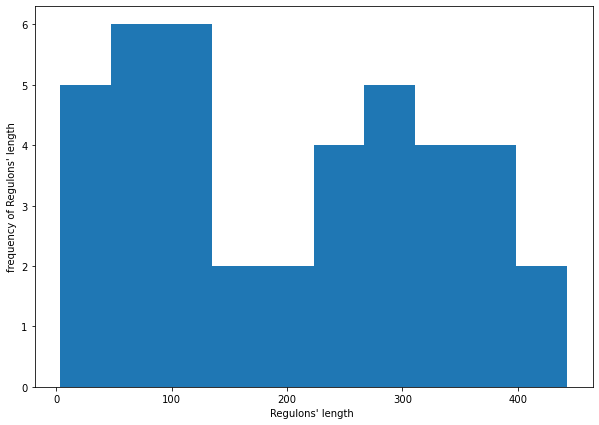

In [56]:
fig = matplotlib.pyplot.figure(figsize =(10, 7))
matplotlib.pyplot.hist(Rank_Regulons)
matplotlib.pyplot.xlabel("Regulons' length ")
matplotlib.pyplot.ylabel("frequency of Regulons' length")
matplotlib.pyplot.show()



In [57]:
# Save the enriched motifs and the discovered regulons to disk.
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)
    
    

In [58]:
df = load_motifs(MOTIFS_FNAME)
with open(REGULONS_FNAME, "rb") as f:
    regulons = pickle.load(f)
    
    

# Third step : AUCell

/Users/farhadzare/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


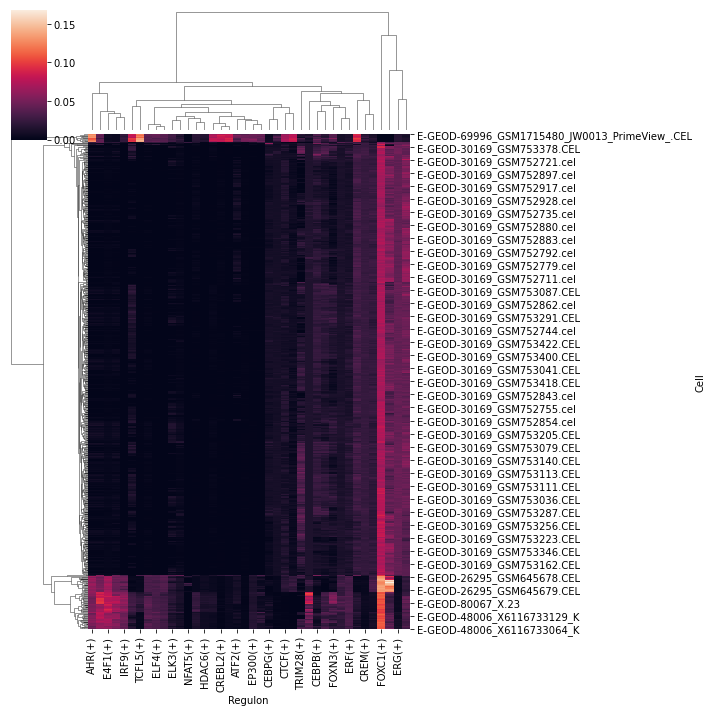

In [59]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=5)
sns.clustermap(auc_mtx, figsize=(10,10))



As an example the regulon Foxc1(+) is active in the cells  E-GEOD-26295-GSM645664,-79 and inactive in the other cells.

In [78]:
import add_visualization

usage: ipykernel_launcher.py [-h] --loom_input LOOM_INPUT --loom_output
                             LOOM_OUTPUT [--num_workers NUM_WORKERS]
ipykernel_launcher.py: error: the following arguments are required: --loom_input, --loom_output


SystemExit: 2

/Users/farhadzare/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [81]:
from pyscenic.binarization import binarize

In [83]:
binar=binarize(auc_mtx)

<Figure size 864x720 with 0 Axes>

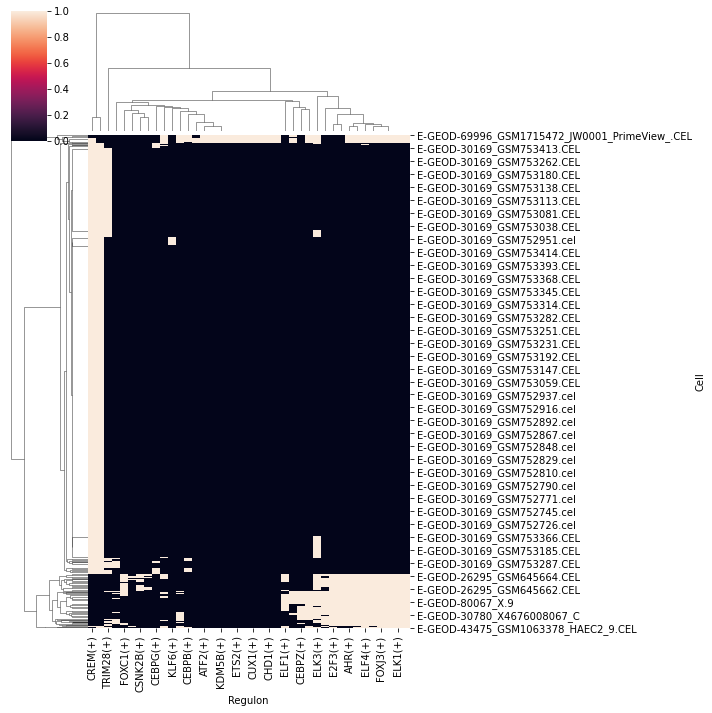

In [127]:
fig = matplotlib.pyplot.figure(figsize =(12, 10))
sns.clustermap(binar[0])
matplotlib.pyplot.show()

This figure shows that the cells are divided into 3 groups; 0ne : E-GEOD-26295-GSM645662-4, E-GEOD-80067_X.9,E-GEOD-30780_x4676006067_C,E-GEOD-43475_GSM1063378_HAEC2_9.CEL and two: E-GEOD-30169_GSM75*.cel Three:E-GEOD-69996_GSM1715472_JW0001_PrimeView_CELL. Howeve, Regulons are divided into 5 groups acoording to their activation in cells. 

In [131]:
binar[0]['FOXC1(+)']

Cell
E-GEOD-30169_GSM752709.cel                     0
E-GEOD-30169_GSM752710.cel                     0
E-GEOD-30169_GSM752711.cel                     0
E-GEOD-30169_GSM752712.cel                     0
E-GEOD-30169_GSM752713.cel                     0
                                              ..
E-GEOD-60152_GSM1466661_stat_siFoxC2_B2.CEL    0
E-GEOD-43475_GSM1063377_HAEC1_2.CEL            0
E-GEOD-43475_GSM1063378_HAEC2_9.CEL            0
E-GEOD-21212_A_GSM530367.CEL                   0
E-GEOD-21212_A_GSM530369.CEL                   0
Name: FOXC1(+), Length: 723, dtype: int64

In [133]:
auc_mtx['FOXC1(+)']

Cell
E-GEOD-30169_GSM752709.cel                     0.067081
E-GEOD-30169_GSM752710.cel                     0.069542
E-GEOD-30169_GSM752711.cel                     0.065929
E-GEOD-30169_GSM752712.cel                     0.063770
E-GEOD-30169_GSM752713.cel                     0.072774
                                                 ...   
E-GEOD-60152_GSM1466661_stat_siFoxC2_B2.CEL    0.056261
E-GEOD-43475_GSM1063377_HAEC1_2.CEL            0.098015
E-GEOD-43475_GSM1063378_HAEC2_9.CEL            0.092302
E-GEOD-21212_A_GSM530367.CEL                   0.089206
E-GEOD-21212_A_GSM530369.CEL                   0.087662
Name: FOXC1(+), Length: 723, dtype: float64

In [134]:
binar[0]['CREM(+)']

Cell
E-GEOD-30169_GSM752709.cel                     1
E-GEOD-30169_GSM752710.cel                     1
E-GEOD-30169_GSM752711.cel                     1
E-GEOD-30169_GSM752712.cel                     1
E-GEOD-30169_GSM752713.cel                     1
                                              ..
E-GEOD-60152_GSM1466661_stat_siFoxC2_B2.CEL    1
E-GEOD-43475_GSM1063377_HAEC1_2.CEL            0
E-GEOD-43475_GSM1063378_HAEC2_9.CEL            0
E-GEOD-21212_A_GSM530367.CEL                   1
E-GEOD-21212_A_GSM530369.CEL                   1
Name: CREM(+), Length: 723, dtype: int64

In [135]:
auc_mtx['CREM(+)']

Cell
E-GEOD-30169_GSM752709.cel                     0.024554
E-GEOD-30169_GSM752710.cel                     0.024631
E-GEOD-30169_GSM752711.cel                     0.024346
E-GEOD-30169_GSM752712.cel                     0.025634
E-GEOD-30169_GSM752713.cel                     0.022422
                                                 ...   
E-GEOD-60152_GSM1466661_stat_siFoxC2_B2.CEL    0.017559
E-GEOD-43475_GSM1063377_HAEC1_2.CEL            0.012912
E-GEOD-43475_GSM1063378_HAEC2_9.CEL            0.005213
E-GEOD-21212_A_GSM530367.CEL                   0.024439
E-GEOD-21212_A_GSM530369.CEL                   0.025259
Name: CREM(+), Length: 723, dtype: float64